In [61]:
import numpy as np
import pandas as pd
import artist_info_helper as aih

import glob, os, re, sys
from datetime import datetime
import pickle
import time
import copy
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('mpl_style_Jeffreson.mplstyle')

In [62]:
def percent_formatter(x, pos):
    return f'{x*100:.1f}%'
def log_format(x, pos):
    return f'{int(x)}'

# analysis for 10000 random artists

In [43]:
df_rnd = pd.read_csv("/n/holystore01/LABS/itc_lab/Users/sjeffreson/serch/artist-database/CLEANED_Spotify_artist_info_Mnth-Lstnrs.csv")
print(df_rnd.columns)
df_rnd.describe()

Index(['ids', 'names', 'popularity', 'followers', 'genres', 'first_release',
       'last_release', 'num_releases', 'num_tracks', 'monthly_listeners'],
      dtype='object')


,popularity,followers,first_release,last_release,num_releases,num_tracks,monthly_listeners
count,15027.000000,1.502700e+04,15027.000000,15027.000000,15027.000000,15027.000000,1.502700e+04
mean,17.454981,9.634407e+04,2007.564118,2019.040194,9.934318,5.285686,2.572302e+05
std,16.868227,1.115855e+06,13.305043,7.597451,7.030349,10.023414,1.942451e+06
min,0.000000,0.000000e+00,1899.000000,1930.000000,1.000000,1.000000,0.000000e+00
25%,2.000000,4.070000e+02,2003.000000,2018.000000,3.000000,1.000000,3.570000e+02
50%,13.000000,2.032000e+03,2011.000000,2022.000000,8.000000,2.000000,4.122000e+03
75%,28.000000,1.146800e+04,2017.000000,2023.000000,18.000000,6.000000,3.870850e+04
max,92.000000,8.726594e+07,2024.000000,2024.000000,20.000000,810.000000,8.135858e+07


In [22]:
# select active artists
df_rnd = df_rnd[df_rnd['last_release'] > 2019]
cnd = (
    (df_rnd['num_releases'] >= 1.*(df_rnd['last_release'] - df_rnd['first_release'])) &
    (2024-df_rnd['first_release'] > 1)
) | (2024-df_rnd['first_release'] <= 1)
df_rnd = df_rnd[cnd]
df_rnd.describe()

,popularity,followers,first_release,last_release,num_releases,num_tracks,monthly_listeners
count,6239.000000,6.239000e+03,6239.000000,6239.000000,6239.000000,6239.000000,6.239000e+03
mean,22.825613,1.520007e+05,2016.116685,2022.877865,13.970027,3.386120,4.242662e+05
std,18.313181,1.541274e+06,4.679895,1.200415,6.509659,12.132556,2.668259e+06
min,0.000000,0.000000e+00,2000.000000,2020.000000,1.000000,1.000000,0.000000e+00
25%,6.000000,7.025000e+02,2013.000000,2022.000000,8.000000,1.000000,1.027000e+03
50%,21.000000,3.789000e+03,2017.000000,2023.000000,16.000000,1.000000,1.443500e+04
75%,36.000000,2.302000e+04,2020.000000,2024.000000,20.000000,4.000000,1.008890e+05
max,92.000000,8.726594e+07,2024.000000,2024.000000,20.000000,810.000000,8.135858e+07


# Artist info for artists featured on Spotify's editorial/curated/public playlists

In [23]:
df_feat = pd.read_csv("/n/holystore01/LABS/itc_lab/Users/sjeffreson/serch/artist-database/Editorial-playlists/CLEANED_featured_Spotify_artist_info.csv")
print(df_feat.columns)
df_feat.describe()

Index(['dates', 'ids', 'names', 'monthly_listeners', 'popularity', 'followers',
       'genres', 'first_release', 'last_release', 'num_releases', 'num_tracks',
       'playlists_found', 'feat_track_ids'],
      dtype='object')


,monthly_listeners,popularity,followers,first_release,last_release,num_releases,num_tracks
count,2.025100e+04,20251.000000,2.025100e+04,20251.000000,20251.000000,20251.000000,20251.000000
mean,7.036190e+06,53.459039,2.853238e+06,2012.787072,2023.339786,16.834527,2.639376
std,1.377954e+07,17.828052,9.206670e+06,43.596561,1.949979,5.133740,4.173280
min,0.000000e+00,0.000000,0.000000e+00,0.000000,1972.000000,1.000000,1.000000
25%,2.157725e+05,40.000000,1.595300e+04,2011.000000,2023.000000,14.000000,1.000000
50%,1.121669e+06,53.000000,1.634480e+05,2017.000000,2024.000000,20.000000,1.000000
75%,6.926014e+06,67.000000,1.371360e+06,2020.000000,2024.000000,20.000000,2.000000
max,1.140272e+08,100.000000,1.137957e+08,2024.000000,2024.000000,20.000000,101.000000


In [24]:
# drop duplicate artists
df_feat = df_feat.drop_duplicates(subset=['ids'])
df_feat.describe()

,monthly_listeners,popularity,followers,first_release,last_release,num_releases,num_tracks
count,7.603000e+03,7603.000000,7.603000e+03,7603.000000,7603.000000,7603.000000,7603.000000
mean,3.359092e+06,48.028278,1.142330e+06,2012.457188,2023.122320,16.479284,2.854663
std,8.027042e+06,16.682012,4.848153e+06,25.690216,2.559891,5.364453,5.038270
min,0.000000e+00,0.000000,0.000000e+00,0.000000,1972.000000,1.000000,1.000000
25%,1.311415e+05,37.000000,9.966500e+03,2010.000000,2023.000000,13.000000,1.000000
50%,5.566620e+05,48.000000,7.767800e+04,2017.000000,2024.000000,20.000000,1.000000
75%,2.476317e+06,60.000000,4.704210e+05,2020.000000,2024.000000,20.000000,2.000000
max,1.135538e+08,100.000000,1.135980e+08,2024.000000,2024.000000,20.000000,101.000000


# plot histograms of each property in df_feat and df_rnd, against each other

In [35]:
vmins = {
    'num_releases': 0,
    'last_release': 2019,
    'first_release': 1960,
    'num_tracks': 0
}
vmaxs = {
    'num_releases': 20,
    'last_release': 2024,
    'first_release': 2024,
    'num_tracks': 100
}
nobins = {
    'num_releases': 20,
    'last_release': 6,
    'first_release': 20,
    'num_tracks': 20
}
titles = {
    'num_releases': 'Number of releases',
    'last_release': 'Last release year',
    'first_release': 'First release year',
    'num_tracks': 'No. tracks, last release'
}

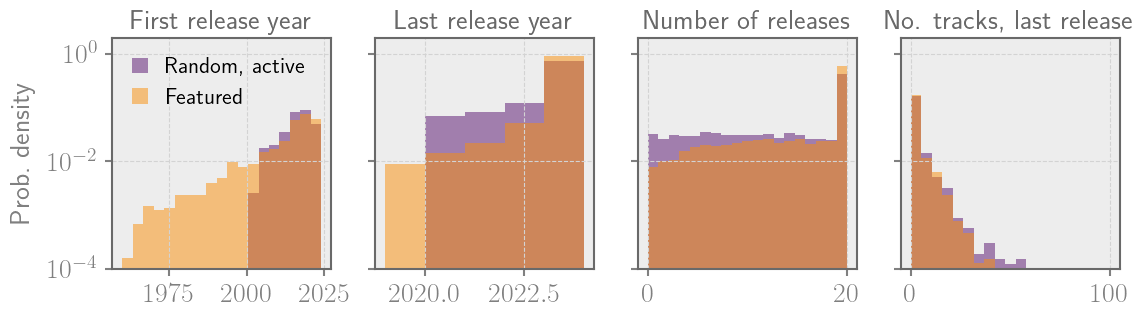

In [42]:
# histograms of each property in df_feat and df_rnd, against each other
fig, axs = plt.subplots(1,4, figsize=(13,3))

for i, col in enumerate(['first_release', 'last_release', 'num_releases', 'num_tracks']):
    axs[i].hist(
        df_rnd[col], bins=np.linspace(vmins[col], vmaxs[col], nobins[col]), log=True, density=True,
        alpha=0.5, label='Random, active', color=plt.cm.inferno(0.25))
    axs[i].hist(
        df_feat[col], bins=np.linspace(vmins[col], vmaxs[col], nobins[col]), log=True, density=True,
        alpha=0.5, label='Featured', color=plt.cm.inferno(0.75))
    axs[i].set_title(titles[col])
    axs[i].set_ylim([1e-4, 2.])
    if i > 0:
        axs[i].set_yticklabels([])
    else:
        axs[i].set_ylabel('Prob.~density')
        axs[i].legend(frameon=False, loc='upper left', fontsize=16, handlelength=0.7)

plt.savefig("/n/holystore01/LABS/itc_lab/Users/sjeffreson/serch/figs/activity_properties.png",
            format='png', bbox_inches='tight', dpi=200)
plt.show()

# and stand-alone for the Monthly Listener counts

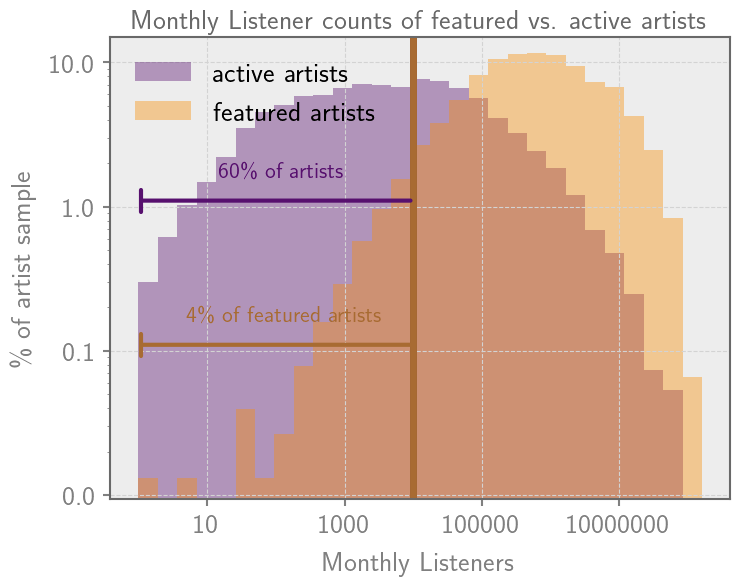

In [64]:


ds_rnd = pd.Series(df_rnd['monthly_listeners'])
ds_feat = pd.Series(df_feat['monthly_listeners'])

plt.figure(figsize=(8, 6))

# plot data
weights_rnd = np.ones_like(ds_rnd) / len(ds_rnd)
plt.hist(ds_rnd, bins=np.logspace(0., 8.2, 30), weights=weights_rnd,
         alpha=0.4, lw=2, log=True, color=plt.cm.inferno(0.25), label='active artists')
weights_feat = np.ones_like(ds_feat) / len(ds_feat)
plt.hist(ds_feat, bins=np.logspace(0., 8.2, 30), weights=weights_feat,
         alpha=0.4, lw=2, log=True, color=plt.cm.inferno(0.75), label='featured artists')

# percentile rank below 10000
# for the random artists
plt.axvline(10000., color=plt.cm.inferno(0.25), lw=5)
percentage_below = ((ds_rnd < 10000.).mean() * 100).round().astype(int)
plt.annotate(f'{percentage_below}\% of artists', xy=(1000., 0.02), xytext=(1000., 0.02),
             va='top', ha='right', color=plt.cm.inferno(0.25), fontsize=16)
plt.annotate('',
    xy=(1., 0.011), xytext=(10000., 0.011),
    arrowprops=dict(arrowstyle="|-|,widthA=0.,widthB=0.5",
                    facecolor=plt.cm.inferno(0.25), edgecolor=plt.cm.inferno(0.25), lw=3),
    fontsize=16
)
# for the featured artists
plt.axvline(10000., color='#a86b32', lw=5)
percentage_below = ((ds_feat < 10000.).mean() * 100).round().astype(int)
plt.annotate(f'{percentage_below}\% of featured artists', xy=(5., 0.002), xytext=(5., 0.002),
             va='top', ha='left', color='#a86b32', fontsize=16)
plt.annotate('',
    xy=(1., 0.0011), xytext=(10000., 0.0011),
    arrowprops=dict(arrowstyle="|-|,widthA=0.,widthB=0.5",
                    facecolor='#a86b32', edgecolor='#a86b32', lw=3),
    fontsize=16
)

plt.xscale('log')
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(percent_formatter))
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(log_format))

plt.legend(frameon=False, loc='upper left')

plt.title(r'Monthly Listener counts of featured vs. active artists', color='dimgrey')
plt.xlabel(r'Monthly Listeners', fontsize=20)
plt.ylabel(r'% of artists', fontsize=16)
plt.ylim([plt.gca().get_ylim()[0], 0.15])
plt.ylabel('\% of artist sample', fontsize=20)

plt.savefig("/n/holystore01/LABS/itc_lab/Users/sjeffreson/serch/figs/monthly_listeners-active.png",
            format='png', bbox_inches='tight', dpi=200)

plt.show()